# Generic NN trainer

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mlflow
import mlflow.keras
import numpy as np
from numpy import ndarray
import pandas as pd
import random
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter1d
import sys

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf

%load_ext lab_black

sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/utils")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/indicators")


from cs_dictionary import CSDictionary
from lstm import lstm_1layer, lstm_2layer
from sequences import sequences
from ticks import Ticks
from metrics import metrics
from utils.plots import plot_marks

In [2]:
argv = [
    "",
    "-c",
    "../src/predictor/params.eurusd.yaml",
    "-f",
    "../data/EURUSD/EURUSD_2018_2020.csv",
    "--window",
    "5",
    "--epochs",
    "50",
    "train",
]
params = CSDictionary(args=argv)

2020-09-29 18:31:18 - INFO  - CSDictionary:__init__           - Using configuration parameters from: ../src/predictor/params.eurusd.yaml


In [7]:
ticks = Ticks(params, params.input_file).scale()
ticks.append_indicator(["trend", "median_filter", "change"])
ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
ticks.append_indicator("trend", column_name="gmf")
ticks.data.head()

KERAS AND TENSORFLOW GRAPHS RESET
RANDOM SEEDS RESET


,open,high,low,close,close_trend,med_filter,change,returns,gmf,gmf_mono,gmf_trend
Datetime,,,,,,,,,,,
2018-01-01,1.2274,1.1598,1.2794,1.2442,1.0,1.2423,0.0000,0.000000,0.001247,0.0,1.0
2018-01-02,1.2292,1.2731,1.2922,1.3358,1.0,1.2442,0.0916,0.073622,0.001905,0.0,1.0
2018-01-03,1.3218,1.2430,1.2794,1.2423,-1.0,1.2753,-0.0935,-0.069996,0.003268,0.0,1.0
2018-01-04,1.2292,1.2873,1.2849,1.3449,1.0,1.2918,0.1026,0.082589,0.005403,0.0,1.0
2018-01-05,1.3309,1.2767,1.3160,1.2753,-1.0,1.2753,-0.0696,-0.051751,0.008347,0.0,1.0


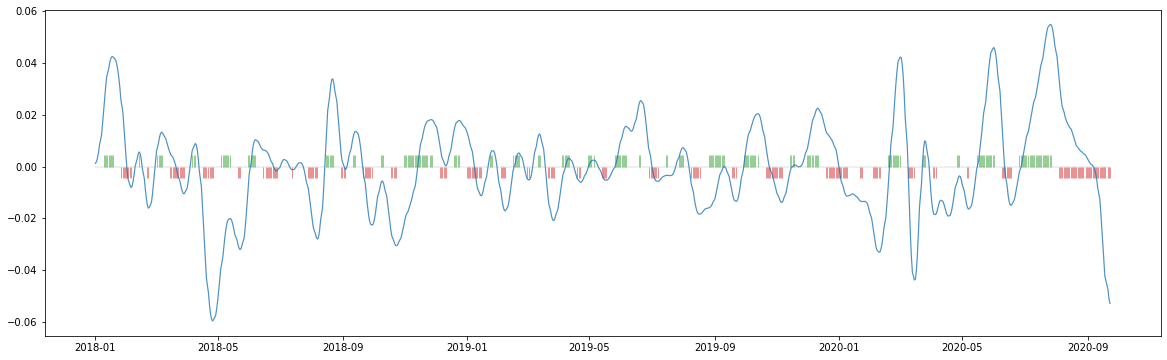

In [6]:
plot_marks(ticks.data, "gmf", "gmf_mono")

In [4]:
def read_ticks():
    ticks = Ticks(params, params.input_file).scale()
    ticks.append_indicator(["trend", "median_filter", "change"])
    ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("trend", column_name="gmf")
    return ticks


def run(X_train, y_train, X_test, y_test, name, binary=False):
    nn = lstm_2layer(params, binary=binary)
    nn.start_training(X_train, y_train, name)
    nn.evaluate(X_test, y_test)
    nn.end_experiment()
    del nn


def split_and_run():
    ticks = read_ticks()
    X_train, y_train, X_test, y_test = ticks.prepare_for_training(
        predict="gmf", train_columns=["gmf"]
    )
    run(X_train, y_train, X_test, y_test, "Reproducibility")
    del (X_train, y_train, X_test, y_test, ticks)

In [5]:
split_and_run()
split_and_run()

KERAS AND TENSORFLOW GRAPHS RESET
RANDOM SEEDS RESET
KERAS AND TENSORFLOW GRAPHS RESET
RANDOM SEEDS RESET
2020-09-28 18:15:26 - INFO  - lstm_2layer:_build_model        - NN lstm_2layer created
2020-09-28 18:16:14 - INFO  - lstm_2layer:evaluate            - Predictions (yhat): (85, 1)
2020-09-28 18:16:14 - INFO  - lstm_2layer:evaluate            - Trend acc.: 0.53
KERAS AND TENSORFLOW GRAPHS RESET
RANDOM SEEDS RESET
KERAS AND TENSORFLOW GRAPHS RESET
RANDOM SEEDS RESET
2020-09-28 18:16:14 - INFO  - lstm_2layer:_build_model        - NN lstm_2layer created
2020-09-28 18:17:02 - INFO  - lstm_2layer:evaluate            - Predictions (yhat): (85, 1)
2020-09-28 18:17:02 - INFO  - lstm_2layer:evaluate            - Trend acc.: 0.53


# Iterable version over different window sizes

In [6]:
# for ws in [5, 10, 15, 20, 25, 30]:
#     print(f"Window size = {ws}")
#     params.window_size = ws
#     X_train, y_train, X_test, y_test = ticks.prepare_for_training(
#         predict="gmf", train_columns=['gmf']
#     )
#     run("GMF with GMF", binary=False)

# Plot $Y$ and $\hat{Y}$